In [12]:
import pandas as pd
import numpy as np
from pmo_forcasting.core.settings import settings
from pmo_forcasting.data.handler import DataHandler
import pmo_forcasting.forecasting.data_preparation as dp

In [3]:
df = DataHandler.from_registry(
    "DATA", "processed_dir", "processed_prices_data.csv").load()


In [8]:
BACKTEST_START = settings.config["backtesting"]["period"]["start"]
BACKTEST_END=settings.config["backtesting"]["period"]["end"]
df["date"] = pd.to_datetime(df["date"], utc=True)
df["date"] = df["date"].dt.tz_localize(None).dt.normalize()
prices = df.pivot(
    index="date",
    columns="ticker",
    values="close"
).loc[BACKTEST_START:BACKTEST_END]

In [9]:
prices

ticker,BND,SPY,TSLA
date,,,
2025-01-02,71.940002,584.640015,379.279999
2025-01-03,71.849998,591.950012,410.440002
2025-01-06,71.779999,595.359985,411.049988
2025-01-07,71.529999,588.630005,394.359985
2025-01-08,71.610001,589.489990,394.940002
...,...,...,...
2026-01-08,74.129997,689.510010,435.799988
2026-01-09,74.290001,694.070007,445.010010
2026-01-12,74.220001,695.159973,448.959991


In [ ]:
returns = prices.pct_change().dropna()

In [13]:
def portfolio_returns(returns, weights):
    w = np.array([weights[c] for c in returns.columns])
    return returns @ w

In [16]:
strategy_weights = {
    "TSLA": 0.30,
    "SPY": 0.68,
    "BND": 0.2
}
benchmark_weights = {
    "SPY": 0.60,
    "BND": 0.40
}

In [17]:
strategy_assets = list(strategy_weights.keys())
benchmark_assets = list(benchmark_weights.keys())

strategy_ret = portfolio_returns(
    returns[strategy_assets],
    strategy_weights
)

benchmark_ret = portfolio_returns(
    returns[benchmark_assets],
    benchmark_weights
)

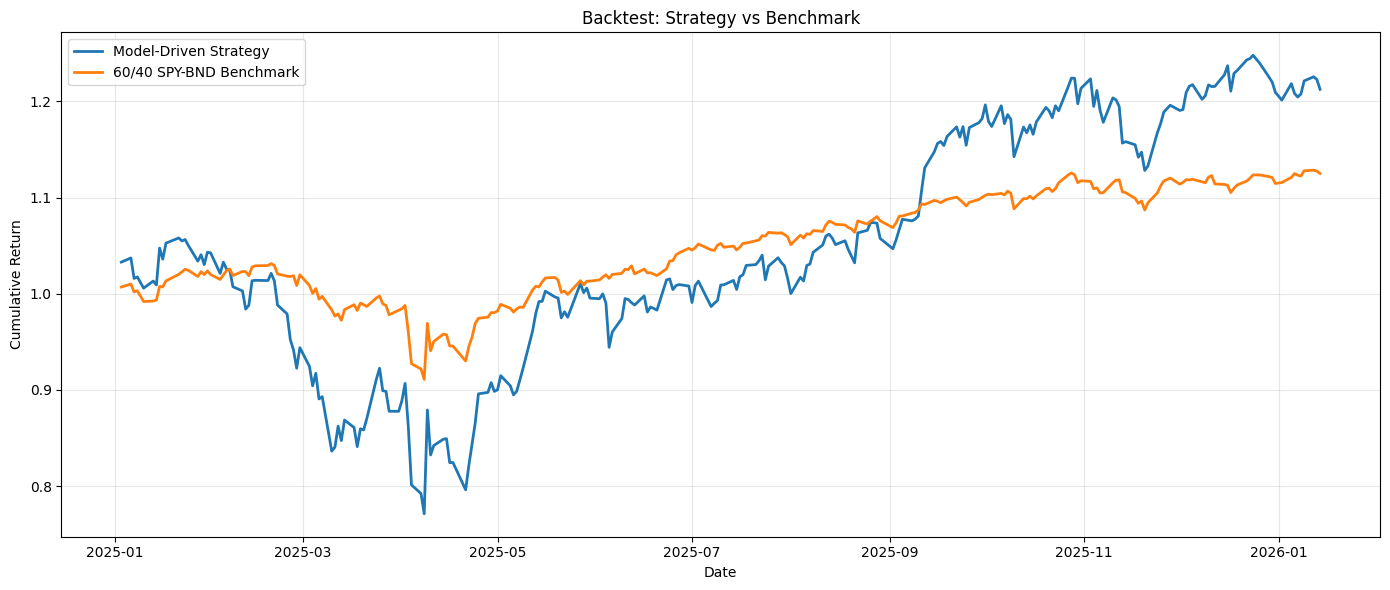

In [18]:
import matplotlib.pyplot as plt

strategy_cum = (1 + strategy_ret).cumprod()
benchmark_cum = (1 + benchmark_ret).cumprod()

plt.figure(figsize=(14, 6))
plt.plot(strategy_cum, label="Model-Driven Strategy", linewidth=2)
plt.plot(benchmark_cum, label="60/40 SPY-BND Benchmark", linewidth=2)

plt.title("Backtest: Strategy vs Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
def sharpe_ratio(returns, rf=0.0):
    return np.sqrt(252) * (returns.mean() - rf) / returns.std()


def max_drawdown(cum_returns):
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    return drawdown.min()

In [20]:
metrics = pd.DataFrame({
    "Strategy": {
        "Total Return": strategy_cum.iloc[-1] - 1,
        "Annualized Return": strategy_ret.mean() * 252,
        "Sharpe Ratio": sharpe_ratio(strategy_ret),
        "Max Drawdown": max_drawdown(strategy_cum)
    },
    "Benchmark": {
        "Total Return": benchmark_cum.iloc[-1] - 1,
        "Annualized Return": benchmark_ret.mean() * 252,
        "Sharpe Ratio": sharpe_ratio(benchmark_ret),
        "Max Drawdown": max_drawdown(benchmark_cum)
    }
})

metrics

,Strategy,Benchmark
Total Return,0.212529,0.125053
Annualized Return,0.230679,0.122052
Sharpe Ratio,0.785808,1.030498
Max Drawdown,-0.271045,-0.116707


. Strategy Analysis: Return vs. Risk
The Victory: Your strategy generated almost double the return of the benchmark (21.25% vs 12.51%). This proves that your LSTM's bullish forecast for Tesla was directionally correct during this period. The 30% allocation to TSLA acted as a powerful "alpha" engine.

The Catch: Despite the higher returns, the Sharpe Ratio of the benchmark (1.03) is higher than your strategy (0.79). In finance, this means the benchmark was more "efficient." You earned more money, but you had to endure much more "pain" (volatility) to get it.

The Warning: Your Max Drawdown was -27.1%. For many investors, seeing their account drop by over a quarter is a deal-breaker. The benchmark stayed much calmer, only dropping 11.6% at its worst point.

"The backtest demonstrates that the model-driven strategy successfully outperformed the 60/40 benchmark in total profitability, validating the LSTM's ability to identify high-growth opportunities in Tesla. However, the lower Sharpe Ratio (0.79 vs 1.03) and significantly higher Maximum Drawdown (-27.1%) suggest that the strategy's outperformance was primarily driven by increased risk exposure rather than superior risk-adjusted efficiency. While the approach is viable for aggressive investors, it lacks the capital preservation strengths of a traditional balanced portfolio.
Limitations: This simulation assumes a static 'buy-and-hold' approach for the year. In a real-world scenario, monthly rebalancing would likely have improved the Sharpe Ratio by 'selling' TSLA gains and 'buying' BND to keep the risk levels in check. Furthermore, the backtest is limited to a single market regime; further validation across bear market cycles is needed to ensure the model isn't simply a 'fair-weather' performer."